## **Library**: 
Load the libraries needed for the project.
Main library use are:
- **Machine learning** : sklearn, shap
- **Data manipulation** : numpy, pandas
- **Plot**: seaborn, matplotlib
- **Python** tools: itertools and pickle

In [58]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import shap

from itertools import product
from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier, 
                              VotingClassifier, StackingClassifier)
from sklearn.base import clone
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     StratifiedKFold, train_test_split, cross_val_score)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm, tree, datasets
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (mean_squared_error, r2_score, f1_score, precision_score, 
                             recall_score, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, classification_report, roc_auc_score)

## **Functions**: 


In [59]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [60]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='binary')
    recall = recall_score(y, predict_y, average='binary')
    precision_more = precision_score(y, predict_y, average=None,labels= [0,1])
    f1 = f1_score(y, predict_y)
    accuracy = accuracy_score(y, predict_y)
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:, 1]) if hasattr(model, "predict_proba") else None
    conf_matrix = confusion_matrix(y, predict_y)

    performances.append({'model': model_name,
                         'split': nsplit,
                         'recall': recall,
                         'f1': f1,
                         'precision': precision,
                        'precision_more': precision_more,
                         'accuracy': accuracy,
                         'roc_auc': roc_auc,
                         'confusion_matrix': conf_matrix.tolist()})



In [61]:
@run_on_splits
def evaluate_2(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='macro')
    recall = recall_score(y, predict_y, average='macro')
    f1 = f1_score(y, predict_y, average='macro')
    accuracy = accuracy_score(y, predict_y)

    performances.append({
        'model': model_name,
        'split': nsplit,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    })

# Example usage:
# evaluate_2(some_model, X_test, y_test, 'test_split', 'model_name')


In [62]:
def save_model(reg, model_name, subset_name):
    with open(f'/Users/sylvainestebe/Code/data_child/models/Q1_{model_name}_{subset_name}.pkl', 'wb') as file:
        pkl.dump(reg, file)

def fit_and_evaluate(model, param_grid, model_name, X_train, y_train, subset_name):
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='precision', cv=5, n_jobs=-1, n_iter=50)
    reg = search.fit(X_train, y_train)
    save_model(reg, model_name, subset_name)
    evaluate(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

def fit_dummy_classifier(X_train, y_train, subset_name):
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    evaluate(model=dummy_clf, model_name=f'dummy_{subset_name}')

def fit_and_evaluate_models(X_train, y_train, subset_name):
    fit_dummy_classifier(X_train, y_train, subset_name)

    # SVM
    fit_and_evaluate(
        svm.SVC(probability=True),
    {'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']}, 
        'svm',
        X_train, y_train, subset_name
    )

    # Decision Tree
    fit_and_evaluate(
        tree.DecisionTreeClassifier(random_state=42), 
            {'max_depth': [2, 5], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']}
    , 
        'tree',
        X_train, y_train, subset_name
    )

    # Random Forest
    fit_and_evaluate(
        RandomForestClassifier(random_state=42), 
            {'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}, 
        'randomforest',
        X_train, y_train, subset_name
    )

    # XGBoost
    fit_and_evaluate(
        XGBClassifier(random_state=42), 
       {'n_estimators': [10, 100],
 'max_depth': [3, 6],
 'learning_rate': [0.01, 0.1],
 'min_child_weight': [1, 3],
 'subsample': [0.8, 1.0]},  
        'xgboost',
        X_train, y_train, subset_name
    )

    # HistGradientBoosting
    fit_and_evaluate(
        HistGradientBoostingClassifier(random_state=42),
        {'learning_rate': [0.01, 0.1],
 'max_iter': [100, 200],
 'max_depth': [3, 6]},  
        'histgradientboosting',
        X_train, y_train, subset_name
    )


In [63]:
def save_model_2(reg, model_name, subset_name):
    with open(f'/Users/sylvainestebe/Code/data_child/models/Q2_{model_name}_{subset_name}.pkl', 'wb') as file:
        pkl.dump(reg, file)

def fit_and_evaluate_2(model, param_grid, model_name, X_train, y_train, subset_name):
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_macro', cv=5, n_jobs=-1, n_iter=50)
    reg = search.fit(X_train, y_train)
    save_model_2(reg, model_name, subset_name)
    evaluate_2(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

def fit_dummy_classifier(X_train, y_train, subset_name):
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    evaluate_2(model=dummy_clf, model_name=f'dummy_{subset_name}')

def fit_and_evaluate_models_2(X_train, y_train, subset_name):
    fit_dummy_classifier(X_train, y_train, subset_name)

    # SVM
    fit_and_evaluate_2(
        svm.SVC(probability=True),
    {'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']}, 
        'svm',
        X_train, y_train, subset_name
    )

    # Decision Tree
    fit_and_evaluate_2(
        tree.DecisionTreeClassifier(random_state=42), 
            {'max_depth': [2, 5], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']}
    , 
        'tree',
        X_train, y_train, subset_name
    )

    # Random Forest
    fit_and_evaluate_2(
        RandomForestClassifier(random_state=42), 
            {'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}, 
        'randomforest',
        X_train, y_train, subset_name
    )

    # XGBoost
    fit_and_evaluate_2(
        XGBClassifier(random_state=42), 
       {'n_estimators': [10, 100],
 'max_depth': [3, 6],
 'learning_rate': [0.01, 0.1],
 'min_child_weight': [1, 3],
 'subsample': [0.8, 1.0]},  
        'xgboost',
        X_train, y_train, subset_name
    )

    # HistGradientBoosting
    fit_and_evaluate_2(
        HistGradientBoostingClassifier(random_state=42),
        {'learning_rate': [0.01, 0.1],
 'max_iter': [100, 200],
 'max_depth': [3, 6]},  
        'histgradientboosting',
        X_train, y_train, subset_name
    )

# **Data**

In [64]:
# Loading dataset
data_child = pd.read_csv("../data/dataset.csv")

In [65]:
import pandas as pd

# Assuming data_child is already loaded from the CSV
# Create a subset of the dataset with variables of interest
data = {
    # Demographic data
    'Age': data_child.Age,
    'Region': data_child.Dep,  # Encode region data as a categorical feature
    'Postcode': data_child.CodePostalBaseline,  # Encode postcode data as a categorical feature
    'SingleMom': data_child.SingleMum,
    'Couple': data_child.Couple,
    'Relationship_type': data_child.Relationship,
    'Educ': data_child.Educ,
    'Income': data_child.IncomeBaseline,
    'Job': data_child.Occupation,
    'Job_partner': data_child.Occupation2,
    'Job_After': data_child.AfterBirthOccupation,

    # Knowledge data
    'NumberKnown': data_child.KnownNbTypeECS,
    'Computer_access': data_child.ComputerYN,

    # Trust data
    'Trust_creche': data_child.TrustCreche1or0,

    # Easy to access data
    'Access': data_child.AccessEasyBaseline,

    # Psy data
    'Happy': data_child.PsyWellBeingHappy,
    'Quite': data_child.PsyWellBeingQuite,
    'Vigou': data_child.PsyWellBeingVigou,
    'Fresh': data_child.PsyWellBeingFresh,
    'Stimu': data_child.PsyWellBeingStimu,

    # Values data
    'ValGenerosity': data_child.ValGenerosity,
    'ValIndependence': data_child.ValIndependence,
    'ValSocialisation': data_child.ValSocialisation,
    'ValObedience': data_child.ValObedience,
    'ValEducation': data_child.ValEducation,
    'ValDK': data_child.ValDK,
    'ValImagination': data_child.ValImagination,

    # Economic difficulties
    'DeprivFood': data_child.DeprivFood,
    'DeprivBills': data_child.DeprivBills,
    'DeprivHolidays': data_child.DeprivHolidays,
    'DeprivHousing': data_child.DeprivHousing,

    # Norms data
    'TradNorm': data_child.TradNormsScore,

    # Output
    'Intention': data_child.Intention,  # Intention to put a baby in a structure
    'Applied': data_child.ECSApp,  # Applied for a structure
    'Use': data_child.ECSUseYes  # Use a structure (hence accepted)
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Check the first few rows of the DataFrame to ensure it loaded correctly
df.head(10)

,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,...,ValDK,ValImagination,DeprivFood,DeprivBills,DeprivHolidays,DeprivHousing,TradNorm,Intention,Applied,Use
0,30,94,94600,False,True,Couple cohabitant,Sup,1000-1500,"Je travaille (y compris si congé maladie, mate...","est au chômage, cherche un emploi",...,0,1,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
1,36,94,94800,False,True,Couple cohabitant,Bac,1000-1500,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",...,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,1,0
2,29,93,93600,False,True,Couple cohabitant,Sup,2500-3000,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",...,0,1,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
3,43,75,75019,False,True,Couple non cohabitant,Sup,2500-3000,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",...,0,1,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
4,40,94,94430,False,True,Couple cohabitant,Sup,3000-4500,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",...,0,0,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
5,44,94,94320,False,True,Couple cohabitant,Sup,- 500,"Je suis étudiant(e), stagiaire ou fait une for...","travaille (y compris si congé maladie, materni...",...,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,0,0
6,33,94,94450,False,True,Couple cohabitant,Sup,- 500,Je suis femme au foyer,"travaille (y compris si congé maladie, materni...",...,0,1,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,0,0
7,47,93,93200,False,True,Couple cohabitant,Bac,NaN,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",...,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,1,1
8,34,75,75012,False,True,Couple cohabitant,Bac,- 500,Je suis femme au foyer,"travaille (y compris si congé maladie, materni...",...,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,No,0,0
9,31,94,94410,False,True,Couple cohabitant,Sup,1500-2000,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",...,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,50,Yes,1,1


## **Preprocessing**: 
Check NA values, Encode Data..

In [66]:
# Check for missing values
print(df.isnull().sum())
# Replace na values with mean
df.Income = df.Income.fillna(str(df.Income.mean))
df.DeprivBills = df.DeprivBills.fillna(str(df.DeprivBills.mean))
df.DeprivHolidays = df.DeprivHolidays.fillna(str(df.DeprivBills.mean))
df.DeprivFood = df.DeprivFood.fillna(str(df.DeprivBills.mean))

Age                   0
Region                0
Postcode              0
SingleMom             0
Couple                0
Relationship_type     0
Educ                  0
Income               97
Job                   0
Job_partner           0
Job_After             0
NumberKnown           0
Computer_access       0
Trust_creche          0
Access                0
Happy                 0
Quite                 0
Vigou                 0
Fresh                 0
Stimu                 0
ValGenerosity         0
ValIndependence       0
ValSocialisation      0
ValObedience          0
ValEducation          0
ValDK                 0
ValImagination        0
DeprivFood            1
DeprivBills          15
DeprivHolidays       19
DeprivHousing         8
TradNorm              0
Intention             0
Applied               0
Use                   0
dtype: int64


In [67]:
# check in their are inconsistency in the dataset 
df.dtypes
# there are some objects data (string) and booleen data. I would like to convert everything in number.

Age                   int64
Region                int64
Postcode              int64
SingleMom              bool
Couple                 bool
Relationship_type    object
Educ                 object
Income               object
Job                  object
Job_partner          object
Job_After            object
NumberKnown           int64
Computer_access      object
Trust_creche          int64
Access               object
Happy                object
Quite                object
Vigou                object
Fresh                object
Stimu                object
ValGenerosity         int64
ValIndependence       int64
ValSocialisation      int64
ValObedience          int64
ValEducation          int64
ValDK                 int64
ValImagination        int64
DeprivFood           object
DeprivBills          object
DeprivHolidays       object
DeprivHousing        object
TradNorm              int64
Intention            object
Applied               int64
Use                   int64
dtype: object

In [68]:
# Initialize and apply LabelEncoder for each categorical column
categorical_columns = ['Job', 'Job_partner', 'Job_After', 'Computer_access',
                       'DeprivFood', 'DeprivBills', 'DeprivHolidays', 'DeprivHousing',
                       'Postcode', 'Region', 'Educ', 'Couple', 'Relationship_type',
                       'Access', 'Happy', 'Quite', 'Vigou', 'Fresh', 'Stimu', 'Intention', 'SingleMom','Income']

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Combine classes into one column
def combine_classes(row):
    if row['Applied'] == 0 and row['Use'] == 0:
        return 0
    elif row['Applied'] == 1 and row['Use'] == 0:
        return 1
    elif row['Applied'] == 1 and row['Use'] == 1:
        return 2

df['Combined'] = df.apply(combine_classes, axis=1)

# Create aggregated columns
df['Total_Deprivation'] = df[['DeprivFood', 'DeprivBills', 'DeprivHolidays', 'DeprivHousing']].sum(axis=1)
df['Total_Values'] = df[['ValGenerosity', 'ValIndependence', 'ValSocialisation', 'ValObedience', 'ValEducation', 'ValDK', 'ValImagination']].sum(axis=1)
df['Total_Psy'] = df[['Happy', 'Quite', 'Vigou', 'Fresh', 'Stimu']].sum(axis=1)

# Scale Age and Income
scaler = StandardScaler()
df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']])

# Check the first few rows of the DataFrame to ensure it loaded correctly
df.head(10)


,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,...,DeprivHolidays,DeprivHousing,TradNorm,Intention,Applied,Use,Combined,Total_Deprivation,Total_Values,Total_Psy
0,-0.419513,2,99,0,1,0,1,-0.714911,4,2,...,3,2,0,1,1,1,2,11,2,18
1,0.647294,2,101,0,1,0,0,-0.714911,4,5,...,4,2,0,1,1,0,1,12,2,14
2,-0.597314,1,55,0,1,0,1,0.336500,4,5,...,3,2,0,1,1,1,2,11,2,17
3,1.891902,0,18,0,1,1,1,0.336500,4,5,...,3,2,0,1,1,1,2,11,2,17
4,1.358499,2,88,0,1,0,1,0.686970,4,5,...,3,2,0,1,1,1,2,11,2,14
5,2.069703,2,79,0,1,0,1,-1.065382,3,5,...,4,2,0,1,0,0,0,12,2,12
6,0.113890,2,90,0,1,0,1,-1.065382,2,5,...,4,2,0,1,0,0,0,12,2,10
7,2.603107,1,31,0,1,0,0,2.088852,4,5,...,4,2,0,1,1,1,2,12,2,12
8,0.291692,0,11,0,1,0,0,-1.065382,2,5,...,4,2,0,0,0,0,0,12,2,12
9,-0.241712,2,86,0,1,0,1,-0.364441,4,5,...,4,2,50,1,1,1,2,12,2,5


## **Exploratory**: 

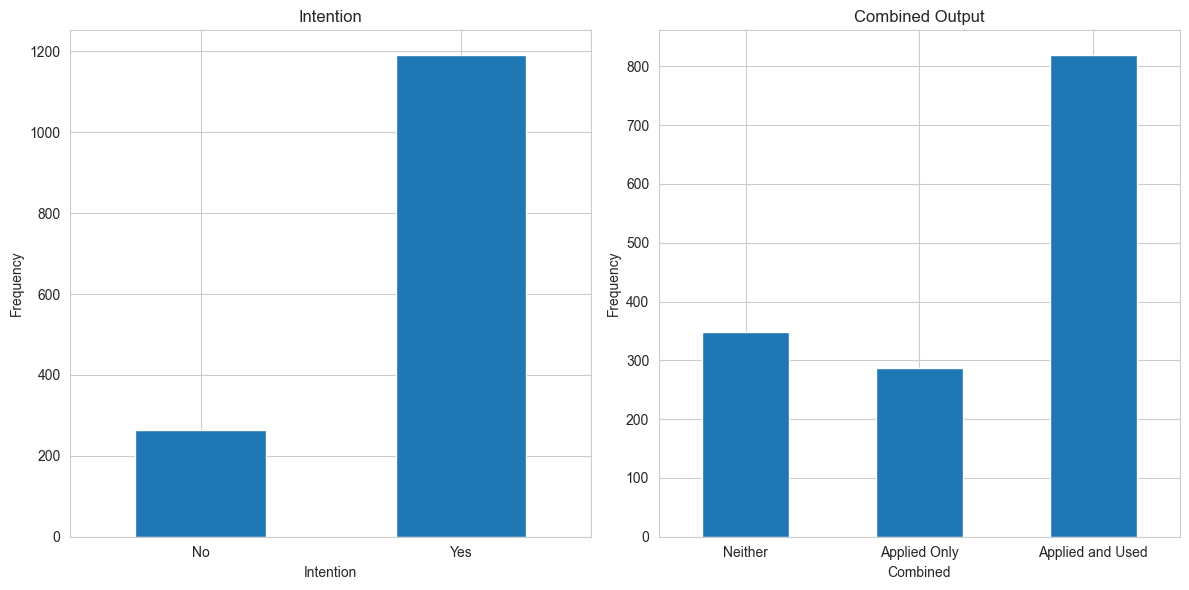

In [69]:
# Visualize the Intention and Combined output using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Intention plot
intention_counts = df["Intention"].value_counts().sort_index(ascending=True)
intention_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Intention')
axes[0].set_xlabel('Intention')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

# Combined plot
combined_counts = df["Combined"].value_counts().sort_index()
combined_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Combined Output')
axes[1].set_xlabel('Combined')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['Neither', 'Applied Only', 'Applied and Used'], rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


In [70]:
# Visualize the distribution of numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

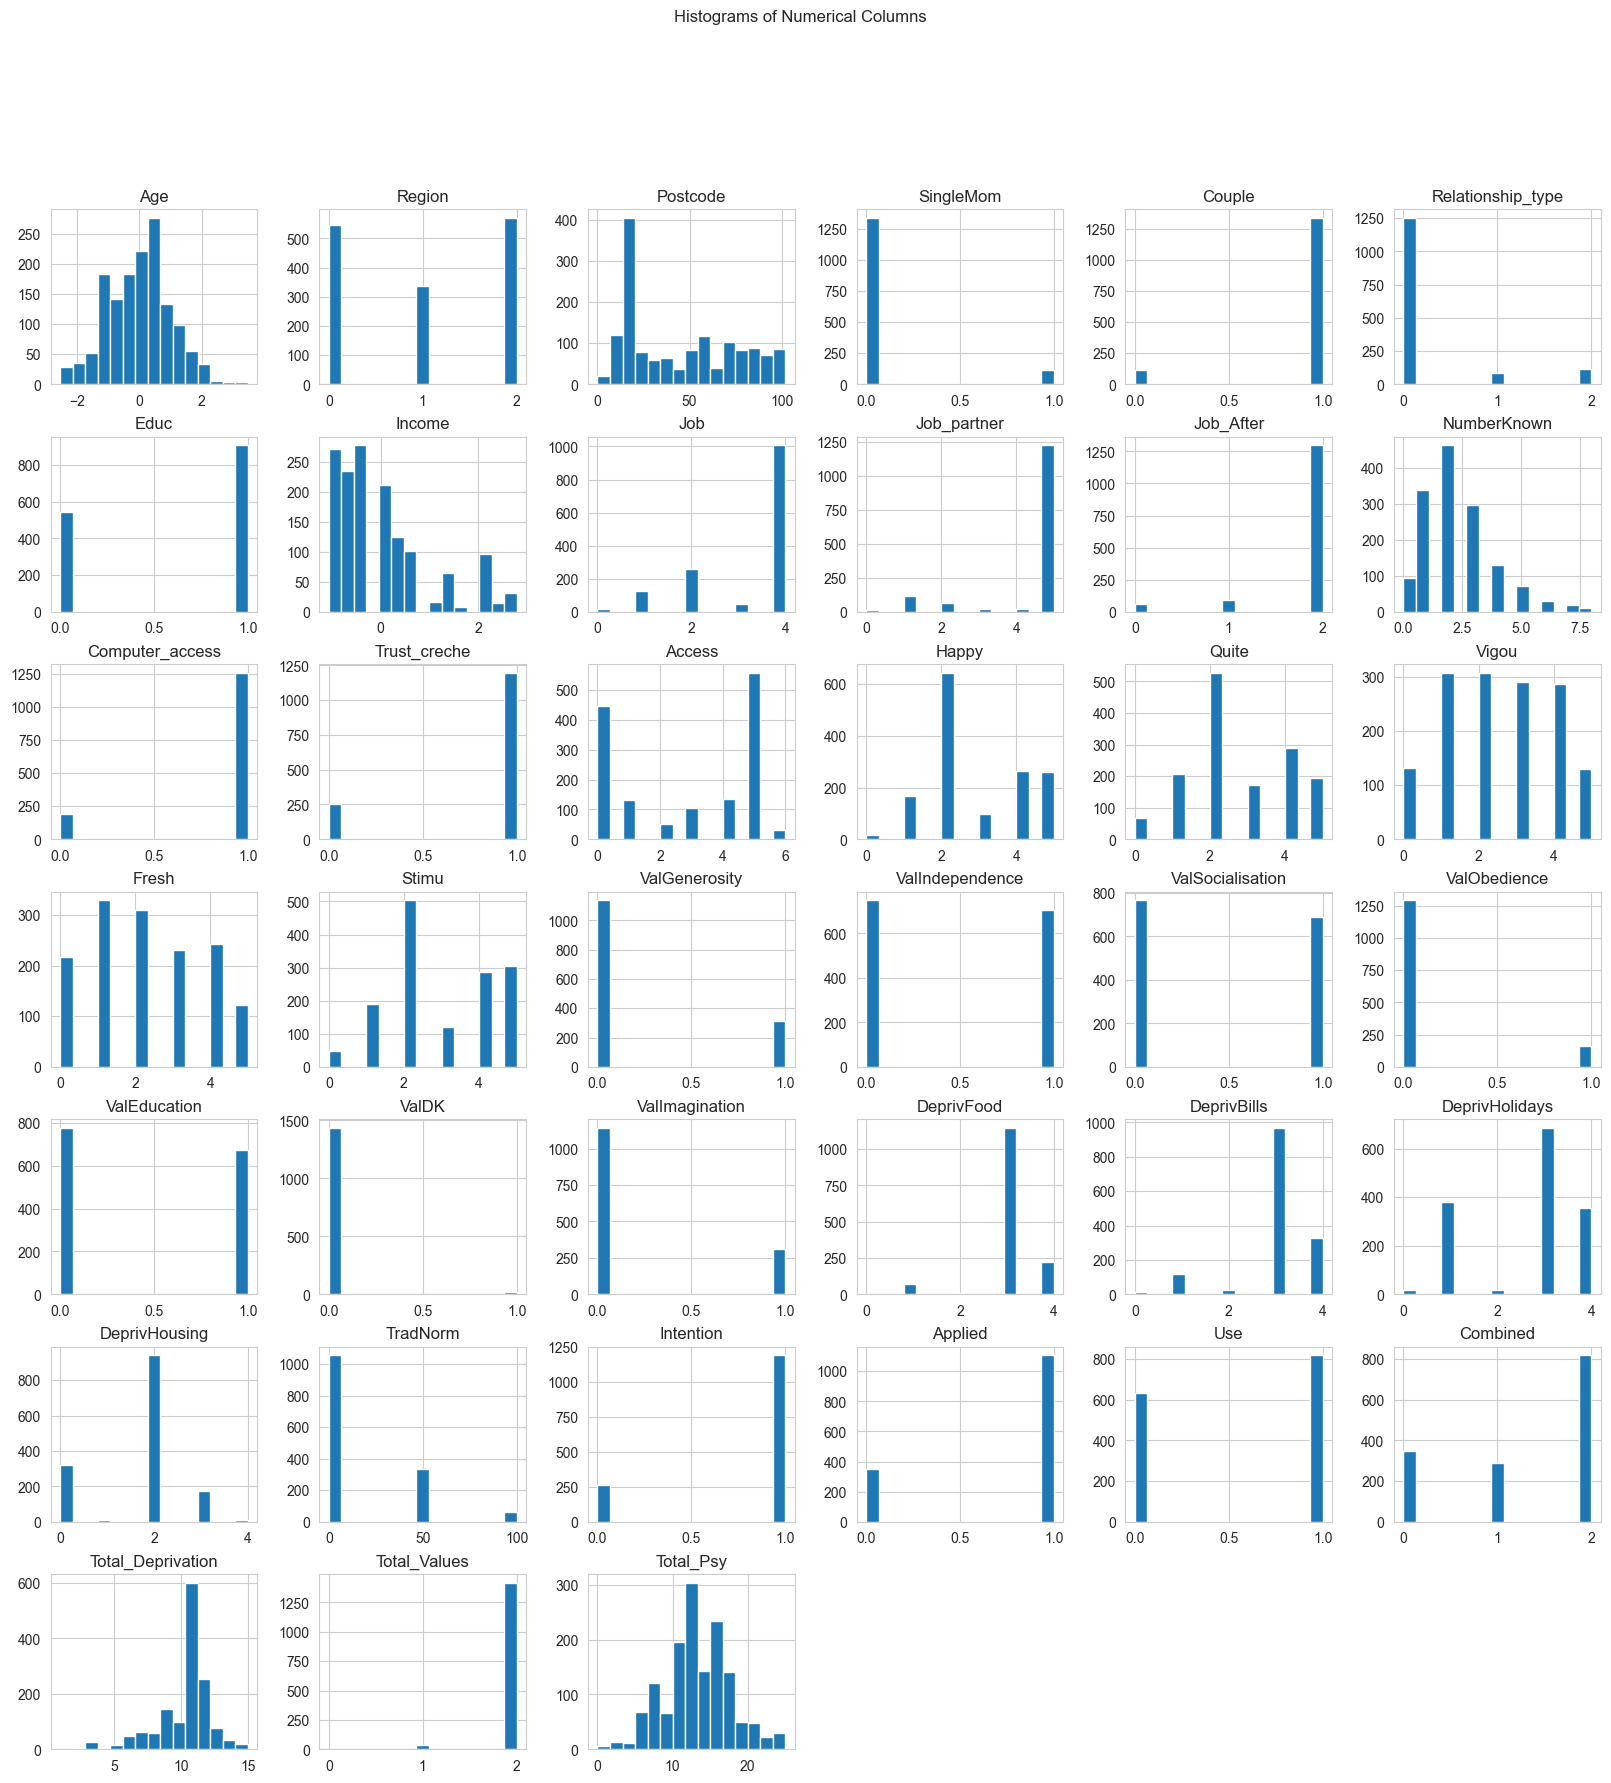

In [71]:
# Visualize the distribution of numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(20, 20), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()

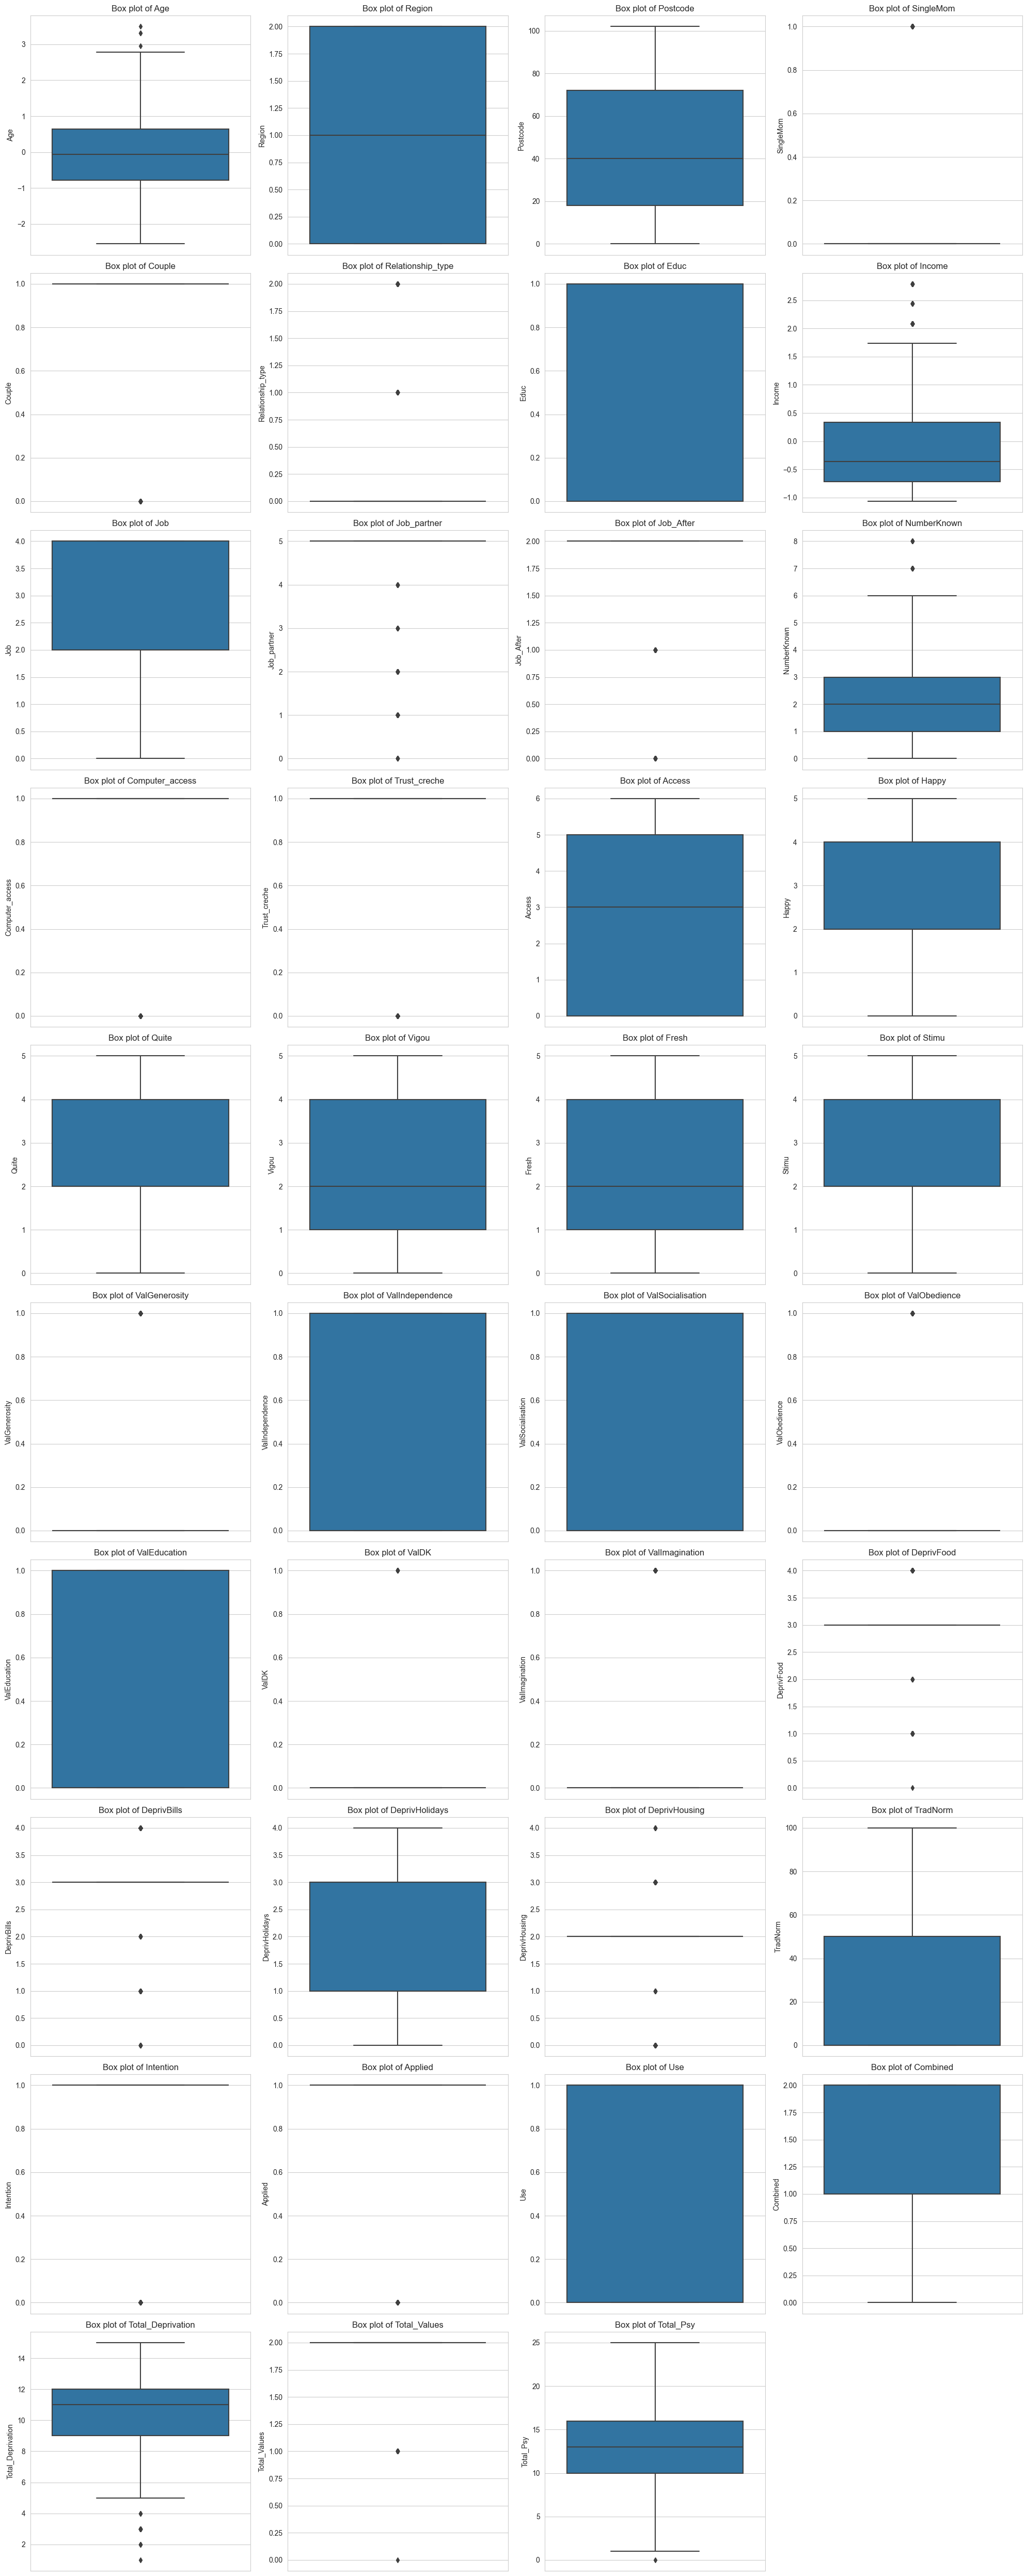

In [72]:
num_cols = len(numerical_columns)
num_rows = (num_cols + 3) // 4  # This will create enough rows to accommodate all columns

# Visualize box plots to check for outliers
plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

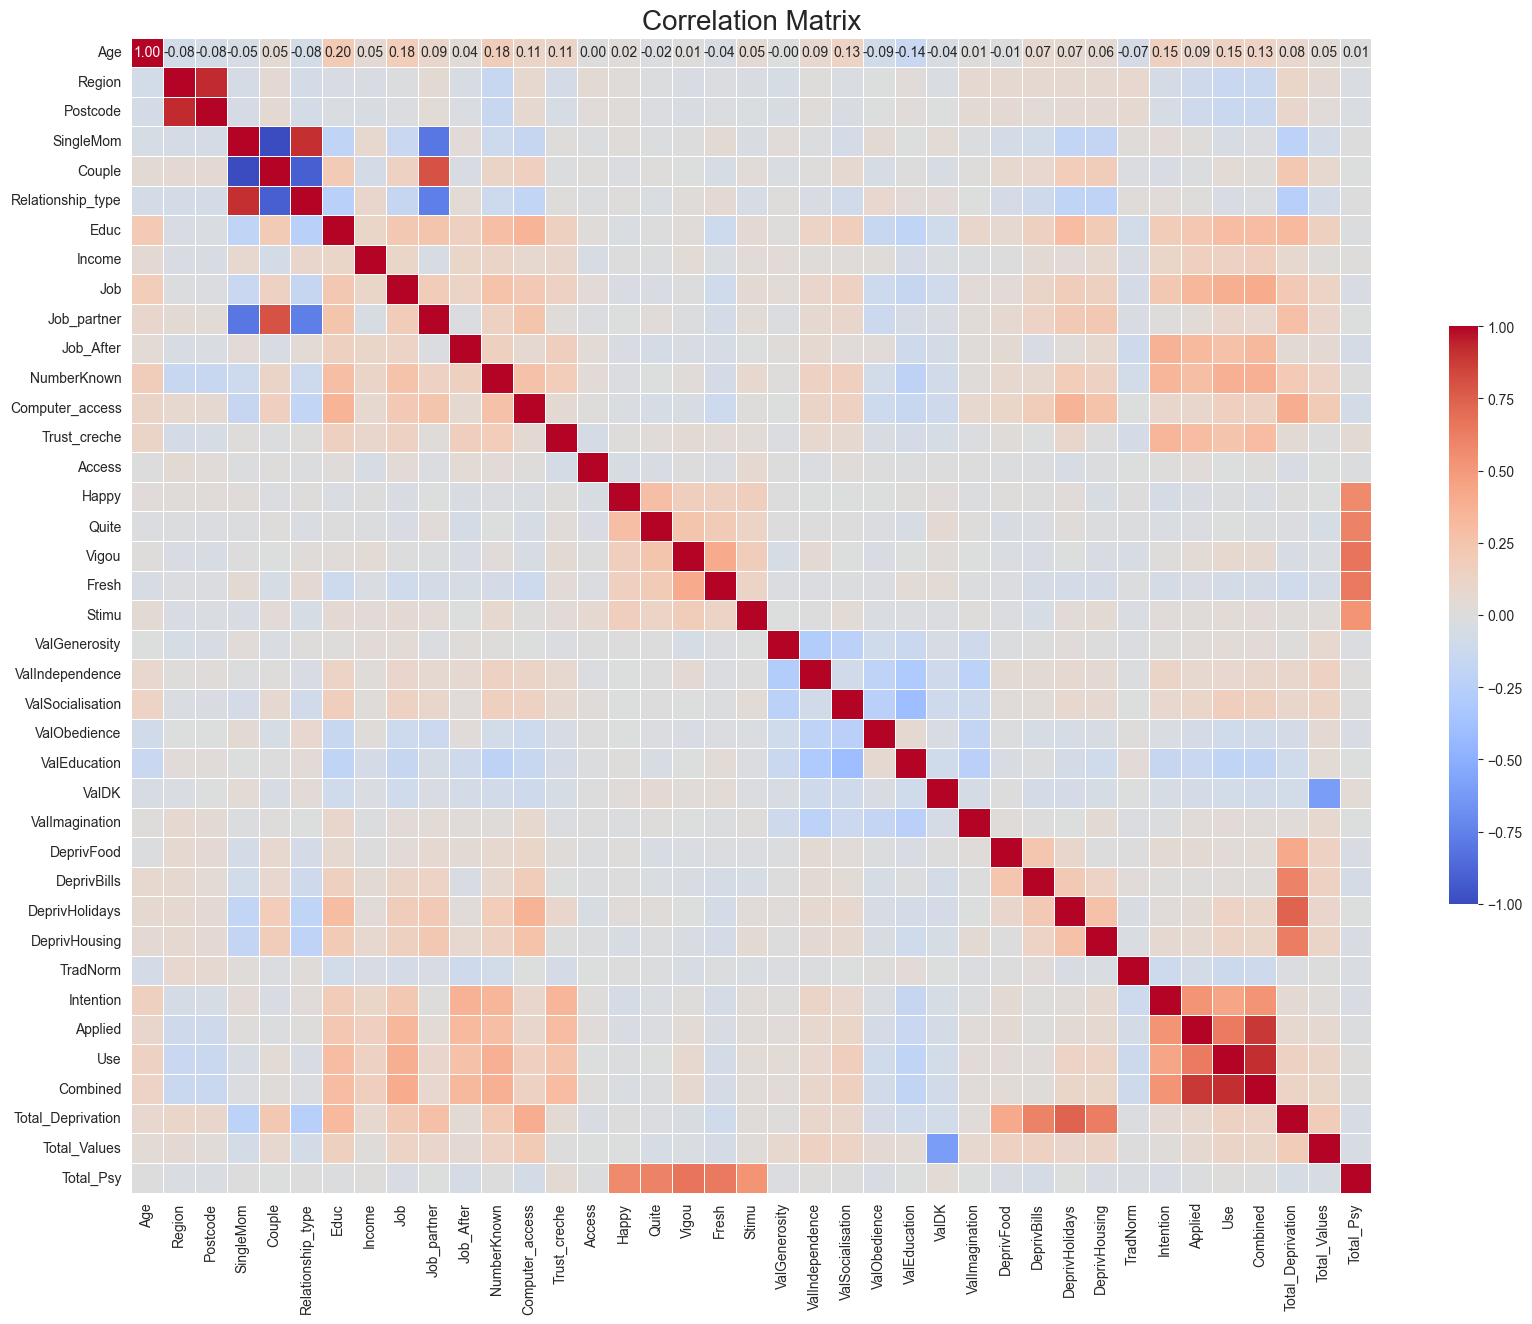

In [73]:
# Visualize correlation matrix
plt.figure(figsize=(20, 15))  # Adjusted size for better visibility
correlation_matrix = df.corr()

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix', size=20)
plt.show()


## **Feature Selection**: 


In [74]:
# Set thresholds for strong positive and negative correlations
positive_threshold = 0.15
negative_threshold = -0.15

# Find features with strong positive and negative correlation with the target variable
target_correlations = correlation_matrix['Intention']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)

Strong Positive Correlations:
 Age             0.150056
Educ            0.189255
Job             0.225074
Job_After       0.369547
NumberKnown     0.349656
Trust_creche    0.344437
Intention       1.000000
Applied         0.523757
Use             0.443746
Combined        0.531023
Name: Intention, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.160461
Name: Intention, dtype: float64


Feature selection for Use and Applied

In [75]:
# Find features with strong positive and negative correlation with the target variable
target_correlations = correlation_matrix['Combined']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)


Strong Positive Correlations:
 Educ                0.297636
Income              0.167620
Job                 0.404149
Job_After           0.322676
NumberKnown         0.375596
Trust_creche        0.307219
ValSocialisation    0.154631
Intention           0.531023
Applied             0.889115
Use                 0.919251
Combined            1.000000
Name: Combined, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.190233
Name: Combined, dtype: float64


# Train/test-split

In [76]:
# Prepare performance dataset to compare differents model before choose the best
data_question_1 = df.copy()
df_select_q1 = data_question_1[['Age', 'Educ', 'Job', 'Job_After', 'NumberKnown', 'Trust_creche', 'ValEducation', 'Intention']]
# Liste des colonnes à enlever
colonnes_a_enlever = ['Intention', 'Applied', 'Use','Combined']
# Enlever les colonnes spécifiées
data_question_1_X = data_question_1.drop(columns=colonnes_a_enlever)
data_question_1_X["Intention"] =  data_question_1.iloc[:,32]

data_question_2_to_filter = df.copy()
data_question_2 = data_question_2_to_filter.drop(data_question_2_to_filter[data_question_2_to_filter.Intention == 0].index)
# Selecting the specified columns for df_select_q2
df_select_q2 = data_question_2[['Educ', 'Job', 'Job_After', 'NumberKnown', 'Computer_access', 'Trust_creche', 'ValSocialisation', 'Combined']]
# Liste des colonnes à enlever
colonnes_a_enlever = ['Intention', 'Applied', 'Use','Combined']
# Enlever les colonnes spécifiées
data_question_2_X = data_question_2.drop(columns=colonnes_a_enlever)
data_question_2_X["Combined"] =  data_question_2.iloc[:,35]

In [77]:
# Create the X (differents predictor) and Y (intention) variables 
X = data_question_1_X.iloc[:,:35].values
y = data_question_1_X.iloc[:,35].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data_question_1_X.columns
    df.to_csv(f'../data/{name}.csv')
print("Datasets saved successfully.")


Datasets saved successfully.


In [78]:
# Create the X (differents predictor) and Y (intention) variables 
X = df_select_q1.iloc[:,:7].values
y = df_select_q1.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = df_select_q1.iloc[:,:8].columns
    df.to_csv(f'../data/{name}_features.csv')
print("Datasets saved successfully.")

Datasets saved successfully.


In [79]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = data_question_2_X.iloc[:,:35].values
y = data_question_2_X.iloc[:,35].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df_2 = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df_2.columns = data_question_2_X.columns
    df_2.to_csv(f'../data/{name}_question2.csv')
print("Datasets saved successfully.")

Datasets saved successfully.


In [80]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = df_select_q2.iloc[:,:7].values
y = df_select_q2.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

columns = [f'feature_{i}' for i in range(7)] + ['Combined']

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = df_select_q2.iloc[:,:8].columns
    df.to_csv(f'../data/{name}_question2_features.csv')
print("Datasets saved successfully.")

Datasets saved successfully.


#  **Question 1**

In [81]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test.csv', index_col=0)
performances = []

# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_features.csv', index_col=0)
performances = []

In [82]:
# Demographic data
X_train, y_train = train.iloc[:, :-26], train.iloc[:, -1]
X_val, y_val = val.iloc[:, :-26], val.iloc[:, -1]
X_test, y_test = test.iloc[:, :-26], test.iloc[:, -1]

fit_and_evaluate_models(X_train, y_train, subset_name="demographic")

# Feature selection
X_train, y_train = train_features.iloc[:, :-1], train_features.iloc[:, -1]
X_val, y_val = val_features.iloc[:, :-1], val_features.iloc[:, -1]
X_test, y_test = test_features.iloc[:, :-1], test_features.iloc[:, -1]

fit_and_evaluate_models(X_train, y_train, subset_name="feature_select")

# All data
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_val, y_val = val.iloc[:, :-1], val.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

fit_and_evaluate_models(X_train, y_train, subset_name="all")

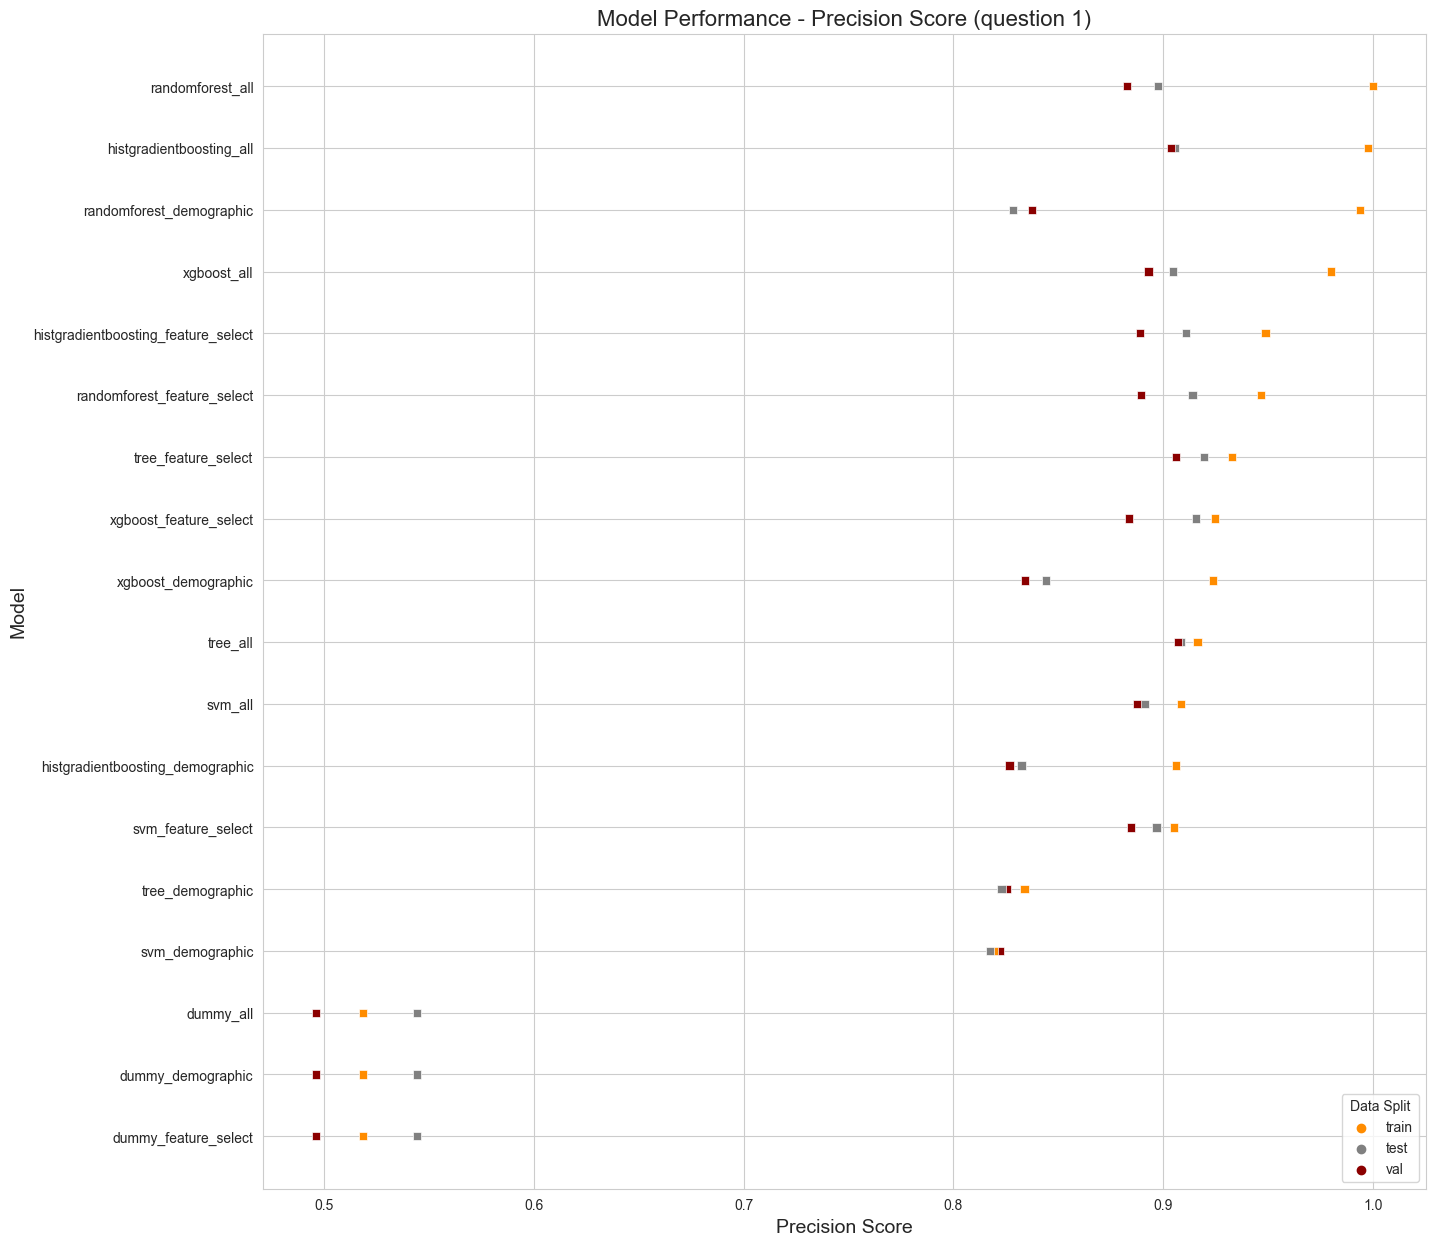

In [83]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(15, 15))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                        y='model', 
                        x='precision', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - Precision Score (question 1)", fontsize=16)
plt.xlabel("Precision Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Optionally save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q1_precision.png', dpi=300)

# Show the plot
plt.show()


In [84]:
# Tune the best models
def fit_and_evaluate_best(X_train, y_train, subset_name):
    xgb_model = XGBClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 10, 100]
    }
    search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)
   # search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring='precision', cv=5, n_jobs=-1, n_iter=1000)
    search.fit(X_train, y_train)
    save_model(search, 'xgboost', subset_name)
    evaluate(model=search.best_estimator_, model_name=f'xgboost_{subset_name}')

In [85]:
# Feature selection
X_train, y_train = train_features.iloc[:, :-1], train_features.iloc[:, -1]
X_val, y_val = val_features.iloc[:, :-1], val_features.iloc[:, -1]
X_test, y_test = test_features.iloc[:, :-1], test_features.iloc[:, -1]

fit_and_evaluate_best(X_train, y_train, subset_name="Best_Model_Feature")

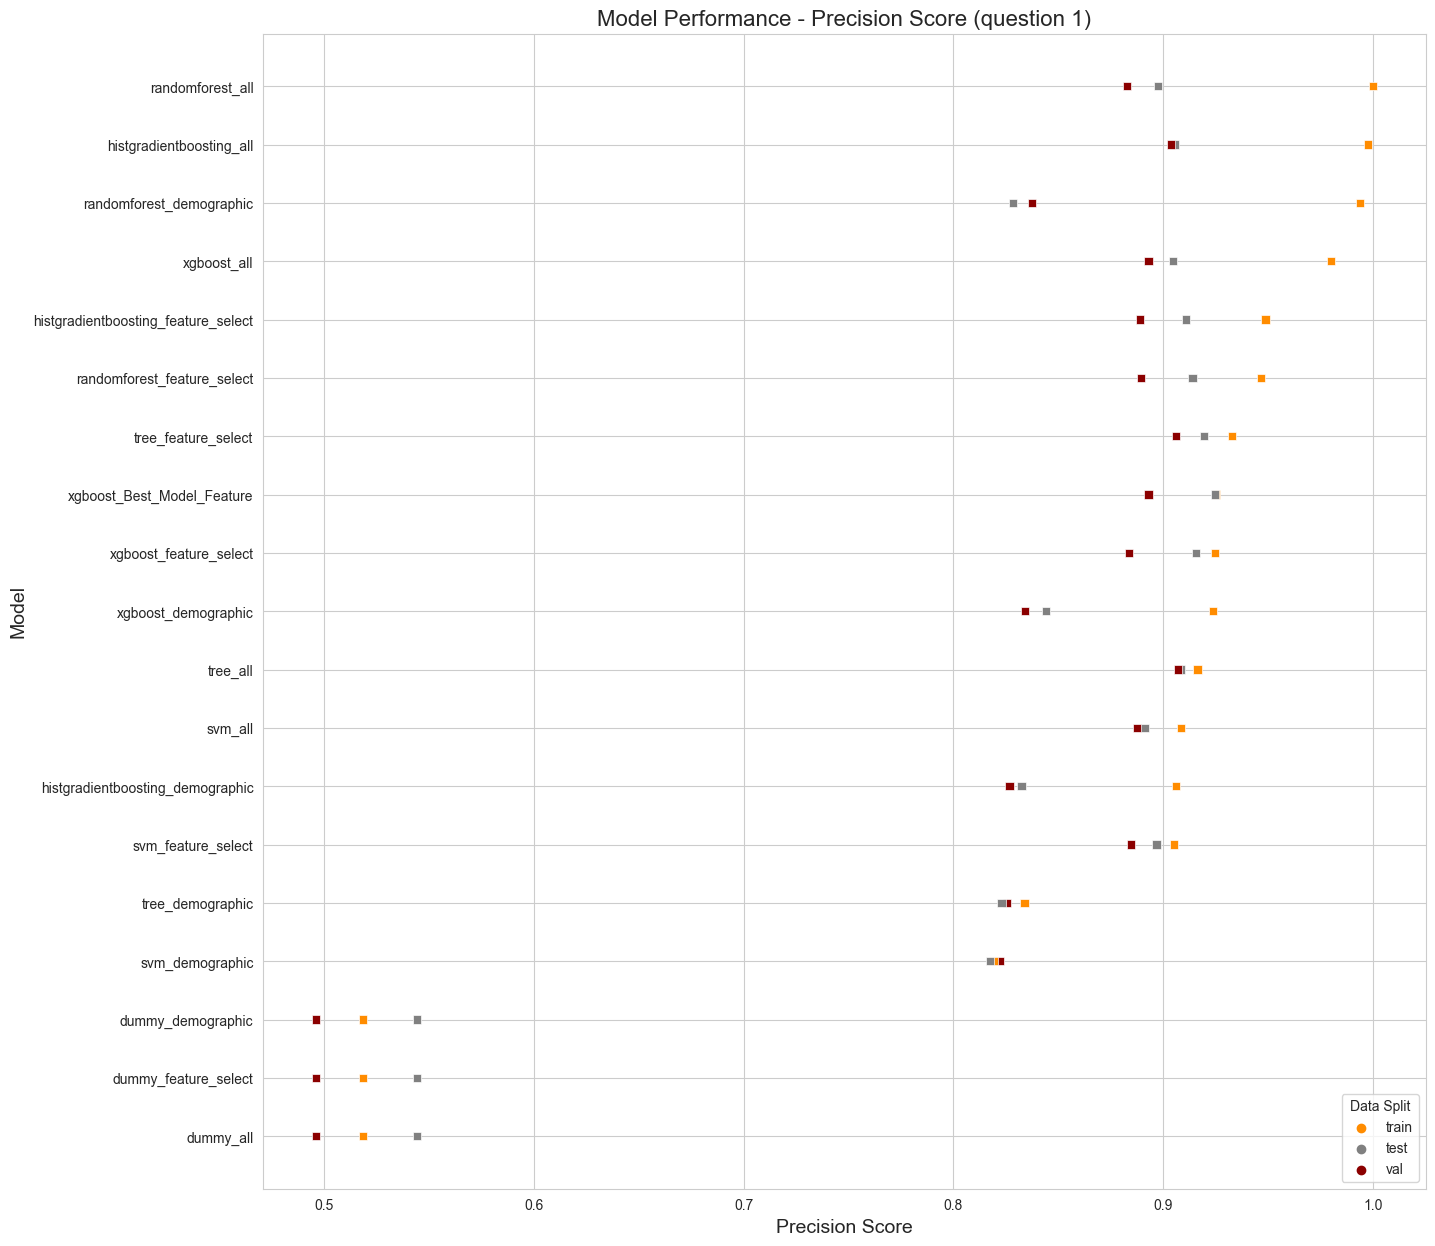

In [86]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(15, 15))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                        y='model', 
                        x='precision', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - Precision Score (question 1)", fontsize=16)
plt.xlabel("Precision Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Optionally save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q1_best_model.png', dpi=300)

# Show the plot
plt.show()


In [87]:
## All data
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

# Load the best model
best_model = pkl.load(open('/Users/sylvainestebe/Code/data_child/models/Q1_xgboost_Best_Model_Feature.pkl', 'rb'))

# Predict on the validation set
best_preds = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix (question 1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q1_confusion_matrice', dpi=300)

plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/Users/sylvainestebe/Code/data_child/models/Q1_xgboost_Best_Model_Feature.pkl'

In [ ]:
print(classification_report(y_test, best_preds))

In [ ]:
best_model.best_estimator_

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create an explainer object
explainer = shap.Explainer(best_model.best_estimator_, X_train)
shap_values = explainer(X_train)

# Create the SHAP summary plot and save it
plt.figure(figsize=(3, 3))
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar', show=False)
plt.savefig("/Users/sylvainestebe/Code/data_child/fig/Q1_features_importance.png", dpi=700)
plt.show()


In [ ]:
# Create the SHAP summary plot and save it
plt.figure(figsize=(3, 3))
shap.summary_plot(shap_values, X_train,max_display=10,show=False)
plt.savefig("/Users/sylvainestebe/Code/data_child/fig/Q1_shap.png", dpi=700)
plt.show()


# **Question 2**

In [ ]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2.csv', index_col=0)
performances = []


# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2_features.csv', index_col=0)
performances = []

In [ ]:
## DEMOGRAPHIC
X_train, y_train = train.iloc[:,:-26], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-26], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-26], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="demographic")
## Features selections
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="features selections")

## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="all")


### Performance

In [ ]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(10, 10))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='f1', ascending=False), 
                        y='model', 
                        x='f1', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'darkred', 'grey'])

# Add plot title and labels
plt.title("Model Performance - F1 Score (Question 2)", fontsize=16)
plt.xlabel("F1 Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Automatically adjust x-axis limits based on data
plt.xlim(perf_df['f1'].min() - 0.05, perf_df['f1'].max() + 0.05)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Optionally save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q2_model_performance_f1.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
# Tune the best models
def fit_and_evaluate_best(X_train, y_train, subset_name):
 # Define the model
    his_model = HistGradientBoostingClassifier(random_state=42)

    # Define the parameter grid for tuning
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_iter': [100, 200],
        'max_depth': [3, 6],
        'min_samples_leaf': [20, 30],
        'l2_regularization': [0.0, 0.1, 1.0]
    }

    search = GridSearchCV(estimator=his_model, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
   # search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring='precision', cv=5, n_jobs=-1, n_iter=1000)
    search.fit(X_train, y_train)
    save_model_2(search, 'histgradient', subset_name)
    evaluate_2(model=search.best_estimator_, model_name=f'best_{subset_name}')

In [ ]:
# Tune the best models
def fit_and_evaluate_optimized_randomforest(X_train, y_train, subset_name):
 # Define the model
    random_tree_perf = RandomForestClassifier(random_state=42)

    # Define the parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    search = GridSearchCV(estimator=random_tree_perf, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
   # search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring='precision', cv=5, n_jobs=-1, n_iter=1000)
    search.fit(X_train, y_train)
    save_model_2(search, 'histgradient', subset_name)
    evaluate_2(model=search.best_estimator_, model_name=f'best_{subset_name}')

In [ ]:
## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_best(X_train, y_train, subset_name="Best_Hist_Gradient")
fit_and_evaluate_optimized_randomforest(X_train, y_train, subset_name="Best_random_forest")

In [ ]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(10, 10))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='f1', ascending=False), 
                        y='model', 
                        x='f1', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'darkred', 'grey'])

# Add plot title and labels
plt.title("Model Performance - F1 Score (Question 2)", fontsize=16)
plt.xlabel("F1 Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Automatically adjust x-axis limits based on data
plt.xlim(perf_df['f1'].min() - 0.05, perf_df['f1'].max() + 0.05)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Optionally save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q2_model_performance_f1.png', dpi=300)

# Show the plot
plt.show()


# Select the best model

### Feature selection and all

In [ ]:
test.iloc[:,:-1]

In [ ]:

## demographic selections
X_train, y_train = train.iloc[:,:-25], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-25], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-25], test.iloc[:,-1]

# Load the best model
best_model = pkl.load(open('/Users/sylvainestebe/Code/data_child/models/Q2_xgboost_demographic.pkl', 'rb'))


In [ ]:
best_model.best_estimator_

In [ ]:
# Predict on the validation set
best_preds = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Question 2)')
plt.savefig('/Users/sylvainestebe/Code/data_child/plots/Q2_confusion.png', dpi=300)

plt.show()


In [ ]:

# Print classification report
print(classification_report(y_test, best_preds))
best_model

In [ ]:
import shap

# Create an explainer object using the best estimator
explainer = shap.Explainer(best_model.best_estimator_, X_train)

# Calculate SHAP values for the training set
shap_values = explainer(X_train)


# Summary plot for each class
for class_idx in range(shap_values.values.shape[2]):
    plt.figure(figsize=(3, 3))
    print(f"Summary plot for class {class_idx}")
    shap.summary_plot(shap_values[:, :, class_idx], X_train,plot_type='bar',show=False)
    plt.savefig(f"/Users/sylvainestebe/Code/data_child/plots/Q2_{class_idx}features_importance.png", dpi=700)
    plt.show()

# Waterfall plot for the first instance in the training set for each class
for class_idx in range(shap_values.values.shape[2]):
    print(f"Waterfall plot for the first instance in class {class_idx}")
    shap.plots.waterfall(shap_values[0, :, class_idx])
